## Setup

In [2]:
import math
import numpy as np
import xarray as xr
import pandas as pd
from copy import deepcopy

from sklearn import feature_selection, svm, preprocessing, model_selection, ensemble
from sklearn import neighbors, decomposition
from sklearn.pipeline import Pipeline

import xgboost
import shap

from nilearn import datasets as nilean_datasets, plotting as nilearn_plotting

import matplotlib.pyplot as plt
import seaborn as sns; sns.set('paper')
import plotly.express as px
from tqdm import tqdm

from src.acnets.datasets import load_julia2018_connectivity

shap.initjs()

# Technical reproducibility
%reload_ext autoreload
%autoreload 3

%reload_ext watermark
%watermark -iv -co -ituhmv

/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Last updated: 2022-02-25T15:11:17.473871+01:00

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1

conda environment: acnets

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Hostname: MP0159

xarray    : 0.21.1
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:28:27) 
[Clang 11.1.0 ]
pandas    : 1.4.0
sklearn   : 1.0.2
nilearn   : 0.9.0
seaborn   : 0.11.2
plotly    : 5.5.0
numpy     : 1.21.5
matplotlib: 3.5.1
shap      : 0.40.0
xgboost   : 1.5.1



In [3]:
# analysis flags and parameters

PARCELLATION = 'dosenbach2010'
CONNECTIVITY_KIND = 'chatterjee' # tangent, precesion

CONNECTIVITY_NAME = f'{PARCELLATION}_{CONNECTIVITY_KIND}'

## Data

In [14]:
X, y = load_julia2018_connectivity(
  parcellation=PARCELLATION,
  kind=CONNECTIVITY_KIND,
  vectorize=True,
  return_y=True,
  only_diagonal=True,
  discard_diagonal=False,
  discard_cerebellum=False,)

# encode y as integers
y_encoder = preprocessing.LabelEncoder()
y = y_encoder.fit_transform(y)

# test/train splits
train, test = model_selection.train_test_split(
  range(len(X)),
  test_size=0.2,
  shuffle=True,
  stratify=y,)

X.columns = [c[1] for c in X.columns]

## Model

In [15]:
rfc = ensemble.RandomForestClassifier(
    max_depth=70,
    max_features=None,
    n_estimators=618,
    n_jobs=-1,
    oob_score=True,
    criterion='gini'
    )

model = Pipeline([
  ('pca', decomposition.PCA(n_components=0.9555456346197084,whiten=True)),
  ('model', rfc)
])

In [17]:
# %%script echo "skipping model evaluation..."

# DEBUG /start

cv_scores = model_selection.cross_val_score(
    model, X, y, n_jobs=-1, scoring='roc_auc',
    cv=model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=20)
    )

print(f'5-Fold AUC (20 repeats): {cv_scores.mean():.3f}'
      f' \N{plus-minus sign} {cv_scores.std():.3f}')

#
%%script echo "skipping permutation test..."

obs_score, rnd_scores, pvalue = model_selection.permutation_test_score(
    model, X, y,
    # cv=model_selection.StratifiedKFold(n_splits=5, shuffle=True),
    cv=model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=20),
    n_jobs=-1,
    n_permutations=100,
    scoring='roc_auc')

print(f'Random AUC (mean): {np.mean(rnd_scores):.3f}')
print(f'Test   AUC (mean): {obs_score:.3f} (p-value {pvalue:.3f})')
# DEBUG /end

5-Fold AUC (20 repeats): 0.500 ± 0.000


UsageError: Line magic function `%%script` not found.


## CV-SHAP

In [27]:
shap_values_cv = []
X_test_indices_cv = []
y_test_cv = []
y_pred_cv = []
expected_value_cv = []

cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=20)

n_splits = cv.get_n_splits(X, y)

for train, test in tqdm(cv.split(X, y), total=n_splits):

    # train the model
    model.fit(X[train], y[train])
    y_pred = model.predict(X[test])

    explainer = shap.TreeExplainer(
        model.named_steps['model'], #data=X[train],
        feature_names=feature_names,
        # algorithm='tree',
        # approximate=True,
        # model_output='raw',
        feature_perturbation='tree_path_dependent',
        # feature_perturbation='interventional',
    )

    shap_values = explainer(X[test], check_additivity=True)

    shap_values_cv.append(shap_values)
    expected_value_cv.append(explainer.expected_value)
    X_test_indices_cv.append(test)
    y_test_cv.append(y[test])
    y_pred_cv.append(y_pred)

100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


In [28]:

# merge CV data
X_test = pd.DataFrame(X[np.hstack(X_test_indices_cv)], columns=feature_names)
y_test = np.hstack(y_test_cv)
y_pred = np.hstack(y_pred_cv)

# merge CV SHAPs
shap_values = shap.Explanation(
  values = np.vstack([sh.values[...,1] for sh in shap_values_cv]),
  base_values = np.hstack([sh.base_values[...,1] for sh in shap_values_cv]),
  data = np.vstack([sh.data for sh in shap_values_cv]),
  feature_names=shap_values_cv[0].feature_names,
  compute_time=np.sum([sh.compute_time for sh in shap_values_cv]),
  output_names=y_encoder.classes_,
  output_indexes=y_pred,
)

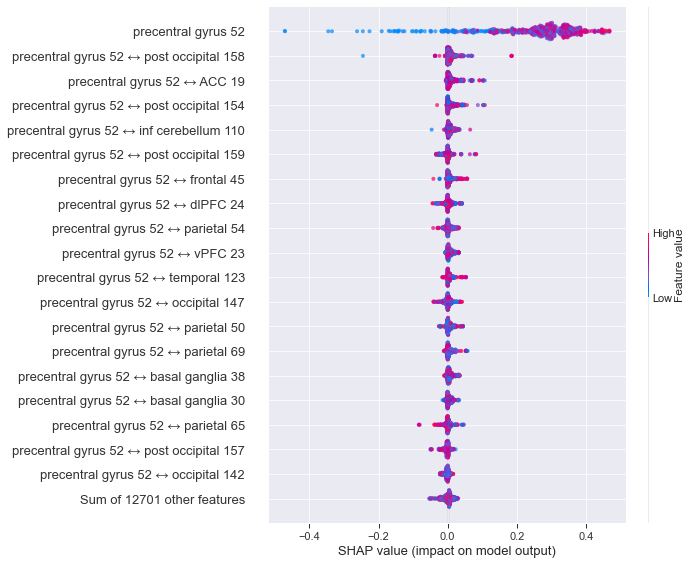

In [29]:
# WORKAROUND: there is a bug in summary plots that changes the ordering of the SHAPs.
#             We deep-copy the shap_values before plotting to keep the original intact.

shap.plots.beeswarm(deepcopy(shap_values), max_display=20, alpha=.7)


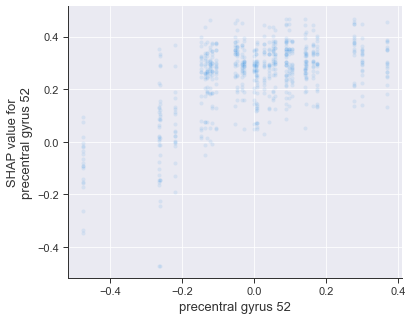

In [32]:
shap.dependence_plot(
  'rank(0)',
  shap_values.values.copy(),
  X_test,
  feature_names=feature_names,
  alpha=.1,
  interaction_index=None,
  # interaction_index='rank(1)'
)


In [ ]:
# TODO subsample to speed up plotting
# shap.force_plot(np.mean(expected_values_cv), shap_values, X_test, feature_names=feature_names)

0.6984375 [308 310 252 353 540  98 512 418 534 416]


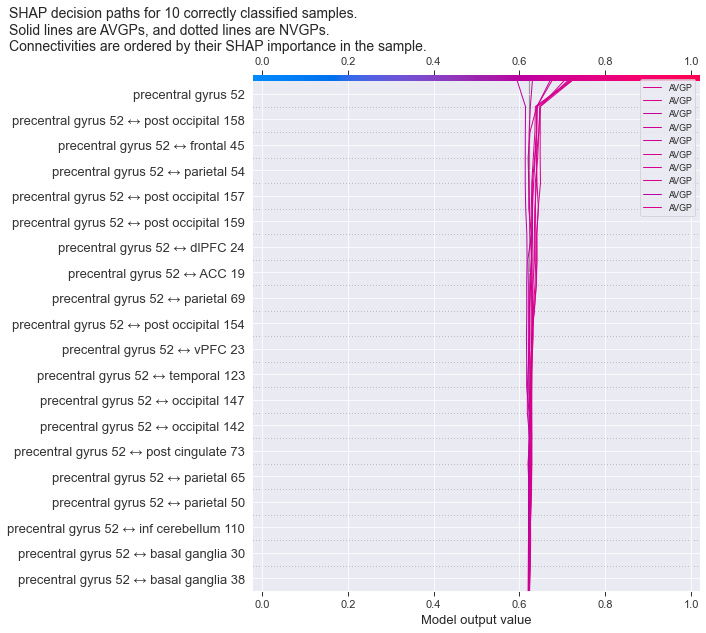

In [35]:
n_samples = 10
select_mask = np.where(y_pred == y_test)[0]     # correctly classified
select_mask = np.where(y_pred != y_test)[0]   # misclassified
# select_mask = np.where(y_pred)[0]             # predicted class
# select_mask = np.where(y_test)[0]             # true class

select_mask = shap.utils.sample(select_mask, n_samples, random_state=None)

print((y_pred == y_test).mean(), select_mask)  # TODO show subject labels
highlight_mask = (y_test[select_mask] == 1)

def legend_labels(idx):
  return [y_encoder.classes_[i] for i in idx.astype(int)]

shap.plots.decision(np.mean(expected_value_cv),
                    shap_values.values[select_mask],
                    link='logit',
                    # feature_order='hclust',
                    # highlight=misclassified,
                    # ignore_warnings=True,
                    legend_labels=legend_labels(highlight_mask),
                    highlight=highlight_mask,
                    show=False,
                    feature_names = feature_names.tolist())

plt.suptitle(f'SHAP decision paths for {n_samples} correctly classified samples.\n'
             'Solid lines are AVGPs, and dotted lines are NVGPs.\n'
             'Connectivities are ordered by their SHAP importance in the sample.',
             ha='left', x=-.3, fontsize=14)
plt.show()

In [37]:

def get_network_name(region, connectivity_name=None):

  if 'difumo' in connectivity_name.lower():
    # TODO find resolution
    atlas = nilean_datasets.fetch_atlas_difumo(
      dimension=64, resolution_mm=2, legacy_format=False)
    labels = atlas.labels.set_index('difumo_names')
    
    name = labels.loc[region,'yeo_networks17']

  elif 'dosenbach2010' in connectivity_name.lower():
    atlas = nilean_datasets.fetch_coords_dosenbach_2010(legacy_format=False)
    labels = pd.concat(
      [pd.DataFrame(v) for k, v in atlas.items() if k != 'description'], axis=1)
    labels.set_index(0, inplace=True)
    
    name = labels.loc[region,'network']
  else:
    raise Exception('Invalid atlas name.')
  
  return name

In [38]:
def get_diag_shap(print_top_n=True, top_n=10):

  agg_shap_values = np.abs(shap_values.values).sum(axis=0)

  shap_diag = pd.Series(agg_shap_values, index=feature_names)

  sorted_shap_indices = np.argsort(agg_shap_values)[::-1]
  top_n_idx = sorted_shap_indices[:top_n]

  if print_top_n:
    print('Top contributing regions:')
    for i, idx in enumerate(top_n_idx):
      region = feature_names[idx]
      net = get_network_name(region, f'{PARCELLATION}_{CONNECTIVITY_KIND}')
      print(f'{i+1}) {region} [{net}]')
      
  return shap_diag


if False:
  shap_diag = get_diag_shap(print_top_n=True)

In [39]:
def get_target_node_name(edge_name):
  nodes = edge_name.split(' ↔ ')
  if len(nodes) == 1:
    return nodes[0]
  elif len(nodes) == 2:
    return  nodes[1]


def get_triu_shap(print_top_n=True, top_n=10):
  agg_shap_values = np.abs(shap_values.values).sum(axis=0)

  shap2d_size = (-1 + math.sqrt(agg_shap_values.shape[0] * 8 + 1)) / 2
  shap2d_size = int(shap2d_size)

  node_names = pd.Series(feature_names[:shap2d_size]).apply(get_target_node_name).values

  shap2d_values = np.zeros((shap2d_size, shap2d_size))
  shap2d_triu_indices = np.triu_indices(shap2d_size, k=0)
  shap2d_values[shap2d_triu_indices] = agg_shap_values
  shap2d_values = shap2d_values + shap2d_values.T - np.diag(np.diag(shap2d_values))

  shap_triu = pd.DataFrame(shap2d_values,
                           index=node_names,
                           columns=node_names)

  sorted_shap_indices = np.argsort(agg_shap_values)[::-1]
  triu_idx = sorted_shap_indices[:top_n]
  row_idx = np.triu_indices(shap2d_size, k=0)[0][triu_idx]
  col_idx = np.triu_indices(shap2d_size, k=0)[1][triu_idx]

  # DEBUG make sure indices are mapped correctly
  assert np.all(shap2d_values[row_idx,col_idx] == agg_shap_values[triu_idx])


  if print_top_n:
    print('Top contributing connectivities:')
    for i, (row, col) in enumerate(zip(row_idx, col_idx)):
      row_region = node_names[row]
      col_region = node_names[col]
      row_net = get_network_name(row_region, f'{PARCELLATION}_{CONNECTIVITY_KIND}')
      col_net = get_network_name(col_region, f'{PARCELLATION}_{CONNECTIVITY_KIND}')  
      print(f'{i+1}) {row_region} \N{left right arrow} {col_region} '
            f'[{row_net} \N{left right arrow} {col_net}]')

  return shap_triu


shap_triu = get_triu_shap(print_top_n=True)

# Top contributing connectivities:
# 1) sup parietal 86 ↔ sup parietal 86 [occipital ↔ occipital]
# 2) vFC 40 ↔ vFC 40 [cingulo-opercular ↔ cingulo-opercular]
# 3) vlPFC 12 ↔ vlPFC 12 [default ↔ default]
# 4) IPS 134 ↔ IPS 134 [sensorimotor ↔ sensorimotor]
# 5) occipital 92 ↔ occipital 92 [sensorimotor ↔ sensorimotor]
# 6) post occipital 153 ↔ post occipital 153 [default ↔ default]
# 7) mid insula 56 ↔ mid insula 56 [occipital ↔ occipital]
# 8) occipital 137 ↔ occipital 137 [sensorimotor ↔ sensorimotor]
# 9) angular gyrus 124 ↔ angular gyrus 124 [sensorimotor ↔ sensorimotor]
# 10) mPFC 4 ↔ mPFC 4 [sensorimotor ↔ sensorimotor]

# Top contributing connectivities:
# 1) sup parietal 86 ↔ sup parietal 86 [occipital ↔ occipital]
# 2) vFC 40 ↔ vFC 40 [cingulo-opercular ↔ cingulo-opercular]
# 3) IPS 134 ↔ IPS 134 [sensorimotor ↔ sensorimotor]
# 4) vlPFC 12 ↔ vlPFC 12 [default ↔ default]
# 5) occipital 137 ↔ occipital 137 [sensorimotor ↔ sensorimotor]
# 6) post occipital 153 ↔ post occipital 153 [default ↔ default]
# 7) mid insula 56 ↔ mid insula 56 [occipital ↔ occipital]
# 8) occipital 92 ↔ occipital 92 [sensorimotor ↔ sensorimotor]
# 9) angular gyrus 124 ↔ angular gyrus 124 [sensorimotor ↔ sensorimotor]
# 10) mPFC 4 ↔ mPFC 4 [sensorimotor ↔ sensorimotor]

# Top contributing connectivities:
# 1) sup parietal 86 ↔ sup parietal 86 [occipital ↔ occipital]
# 2) vFC 40 ↔ vFC 40 [cingulo-opercular ↔ cingulo-opercular]
# 3) vlPFC 12 ↔ vlPFC 12 [default ↔ default]
# 4) IPS 134 ↔ IPS 134 [sensorimotor ↔ sensorimotor]
# 5) occipital 137 ↔ occipital 137 [sensorimotor ↔ sensorimotor]
# 6) post occipital 153 ↔ post occipital 153 [default ↔ default]
# 7) mid insula 56 ↔ mid insula 56 [occipital ↔ occipital]
# 8) occipital 92 ↔ occipital 92 [sensorimotor ↔ sensorimotor]
# 9) angular gyrus 124 ↔ angular gyrus 124 [sensorimotor ↔ sensorimotor]
# 10) mPFC 4 ↔ mPFC 4 [sensorimotor ↔ sensorimotor]

Top contributing connectivities:
1) precentral gyrus 52 ↔ precentral gyrus 52 [cerebellum ↔ cerebellum]
2) precentral gyrus 52 ↔ post occipital 158 [cerebellum ↔ cerebellum]
3) precentral gyrus 52 ↔ ACC 19 [cerebellum ↔ cingulo-opercular]
4) precentral gyrus 52 ↔ post occipital 154 [cerebellum ↔ cingulo-opercular]
5) precentral gyrus 52 ↔ inf cerebellum 110 [cerebellum ↔ cingulo-opercular]
6) precentral gyrus 52 ↔ post occipital 159 [cerebellum ↔ cerebellum]
7) precentral gyrus 52 ↔ frontal 45 [cerebellum ↔ cerebellum]
8) precentral gyrus 52 ↔ dlPFC 24 [cerebellum ↔ cerebellum]
9) precentral gyrus 52 ↔ parietal 54 [cerebellum ↔ cerebellum]
10) precentral gyrus 52 ↔ vPFC 23 [cerebellum ↔ cingulo-opercular]


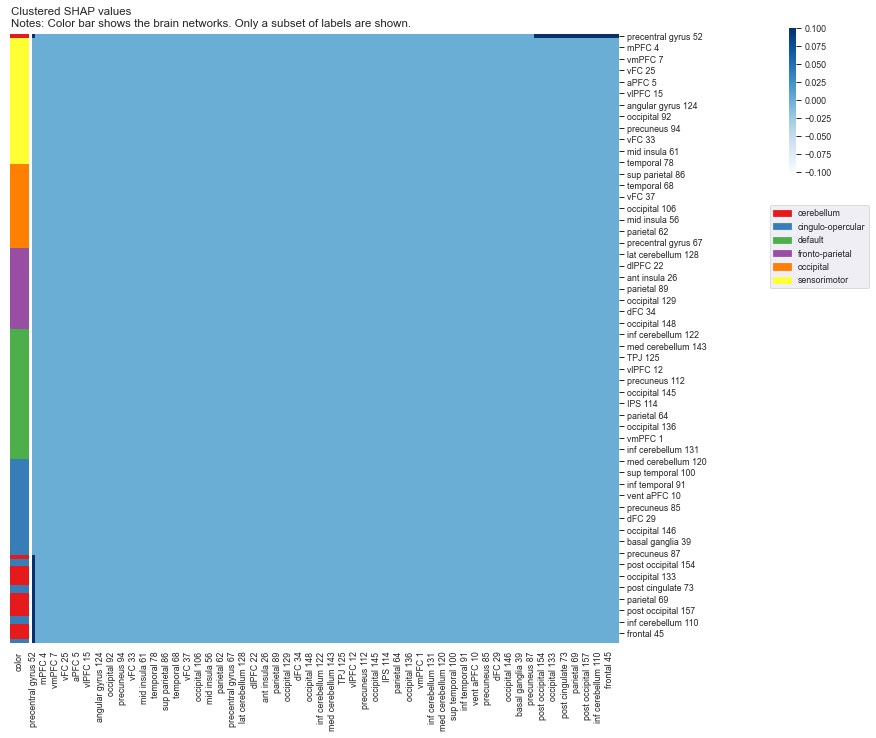

In [43]:
if False:
  network_names = shap_diag.index.to_frame(name='network').apply(
    lambda x: get_network_name(x, f'{PARCELLATION}_{CONNECTIVITY_KIND}'))  
else:
  network_names = shap_triu.index.to_frame(name='network').apply(
    lambda x: get_network_name(x, f'{PARCELLATION}_{CONNECTIVITY_KIND}'))


palt = dict(zip(network_names['network'].unique(),
                sns.color_palette('Set1', network_names.nunique()['network'])))

network_colors = network_names.apply(
  lambda x: pd.Series((palt[x['network']], x['network'])), axis=1)
network_colors.rename(columns={0:'color', 1:'network'}, inplace=True)
network_colors.index.name = 'region'

import matplotlib.patches as mpatches

network_colors_legend = [mpatches.Patch(color=c, label=n)
                     for l,c,n in network_colors.drop_duplicates('network').itertuples()]

g = sns.clustermap(
  shap_triu,
  figsize=(10,10),
  row_colors=network_colors[['color']],
  robust=True,
  dendrogram_ratio=0.0001,
  cbar_pos=(1.1, .79, 0.01, 0.2),
  cmap='Blues')

legend2=g.ax_heatmap.legend(
  loc='center left',
  bbox_to_anchor=(1.25,0.65),
  handles=network_colors_legend,
  frameon=True)

plt.suptitle('Clustered SHAP values\n'
             'Notes: Color bar shows the brain networks. '
             'Only a subset of labels are shown.', x=0.02, y=1.02, ha='left')

plt.show()

## interactive heatmap (but not clustered)
# fig = px.imshow(shap2d, aspect='auto', height=800)
# fig.show()

In [41]:

from nilearn import plotting

if 'dosenbach2010' in PARCELLATION:
  atlas = nilean_datasets.fetch_coords_dosenbach_2010(legacy_format=False)
  atlas_coordinates = atlas['rois'].values
elif 'difumo' in PARCELLATION:
  atlas = nilean_datasets.fetch_atlas_difumo(64, 2, legacy_format=False)
  atlas_coordinates = plotting.find_probabilistic_atlas_cut_coords(maps_img=atlas.maps)
  labels = atlas.labels.set_index('difumo_names')

In [ ]:
plotting.plot_connectome(
  shap_diag, atlas_coordinates,
  node_color=network_colors['color'],
  colorbar=True,
  node_size=shap_diag,
  edge_cmap='Blues',
  title='SHAP values of the edges and aggregated node values.',
  edge_threshold='99%')

plt.gca().legend(
  loc='center left',
  bbox_to_anchor=(2,0.5),
  handles=network_colors_legend,
  frameon=True)

plt.show()

In [42]:
#  nodes are sized by their self-loop (diagonals in the adjacency matrix)
node_strength = np.diag(shap_triu) / 5

nilearn_plotting.plot_connectome(
  shap_triu, atlas_coordinates,
  node_color=network_colors['color'],
  colorbar=True,
  node_size=node_strength,
  edge_cmap='Blues',
  title='SHAP values of the edges and aggregated node values.',
  edge_threshold='99%')

plt.gca().legend(
  loc='center left',
  bbox_to_anchor=(2,0.5),
  handles=network_colors_legend,
  frameon=True)

plt.show()

NameError: name 'network_colors' is not defined

In [ ]:

# DIAGONAL Connectivities

nilearn_plotting.plot_markers(
    shap_diag,
    atlas_coordinates,
    node_size=shap_diag / 20,
    title='Node strength (aggregated Diagonal SHAPs)',
    node_cmap='Blues'
)

plt.show()

In [ ]:
# METHOD 2: nodes are sized by the sum of their edge weights to all other nodes

node_strength = np.sum(shap_triu.values, axis=1).reshape(-1, 1)
node_strength = preprocessing.StandardScaler().fit_transform(shap_triu.values)
node_strength = node_strength.sum(axis=1) * 10

plotting.plot_markers(
    node_strength,
    atlas_coordinates,
    node_size=node_strength,
    title='Node strength (aggregated SHAP values)',
    node_cmap='Blues'
)

plt.show()

In [ ]:
if not FIT_DIAGONAL:
    view = plotting.view_connectome(
        shap_triu.values, atlas_coordinates,
        node_color=network_colors['color'],
        node_size=node_strength / 50, edge_threshold=5,
        colorbar_fontsize=12,
        title=f'TriUSHAP values ({PARCELLATION}_{CONNECTIVITY_KIND})')

view

In [ ]:
if FIT_DIAGONAL:
    view = plotting.view_markers(
        atlas_coordinates,
        marker_color=network_colors['color'],
        marker_size=shap_diag / 50,
        title=f'Diagonal SHAP values ({PARCELLATION} {CONNECTIVITY_KIND})')

    plt.gca().legend(
    loc='center left',
    bbox_to_anchor=(2,0.5),
    handles=network_colors_legend,
    frameon=True)

view